# Двумерные уравнения "мелкой воды" (shallow water equations)

Данный код решает двумерные уравнения "мелкой воды" — важную модель сплошной среды, имеющую приложения для моделирования атмосферы и океанов планет. В качестве задания предлагается промоделировать ряд задач геофизики (рассмотреть уравнения при наличии силы Кориолиса и переменной глубины дна. В качестве референса и начальных данных можно использовать ресурс https://www.met.reading.ac.uk/~swrhgnrj/shallow_water_model/

## Уравнения модели

Уравнения имеют вид:

$$
\begin{aligned}
\frac{\partial h}{\partial t} + \frac{\partial (h v_x)}{\partial x} + \frac{\partial (h v_y)}{\partial y} & = 0 \quad &\text{(уравнение на высоту столба жидкости } h) \\
\frac{\partial (h v_x)}{\partial t} + \frac{\partial (h v_x^2 + \frac{1}{2}g h^2)}{\partial x} + \frac{\partial (h v_x v_y)}{\partial y} & = -g h \frac{\partial b}{\partial x} + f_C h v_y \quad &\text{(уравнение для скорости жидкости } v_x) \\
\frac{\partial (h v_y)}{\partial t} + \frac{\partial (h v_x v_y)}{\partial x} + \frac{\partial (h v_y^2 + \frac{1}{2}g h^2)}{\partial y} & = -g h \frac{\partial b}{\partial y} - f_C h v_x\quad &\text{(уравнение для скорости жидкости } v_y)
\end{aligned}
$$

где:
- $g$ — ускорение свободного падения
- $b$ — функция рельефа бассейна — зависимость высоты дна от (x,y) (в правую часть уравнений входит ее градиент)
- $f_C$ — параметр Кориолиса, связанный с вращением Земли (или другой планеты)

## Компактная форма записи

Система может быть записана в векторной форме в виде законов сохранения:

$$
\frac{\partial \vec{U}}{\partial t} + \frac{\partial \vec{F_x}}{\partial x} + \frac{\partial \vec{F_y}}{\partial y} = \vec{S}
$$

## Технические детали

Программа реализует конечно-объемную схему второго порядка точности (в областях гладкости течения) для решения уравнений мелкой воды. Для расчета потоков величин используется метод $HLL$. Для уточнения величин используется кусочно-линейный метод с ограничитилем $vanLeer$ и использованием схемы $MUSCL-Hancock$. Для учета переменной формы дна (bathimetry) и силы Кориолиса реализован метод расщепления по физическим процессам со вторым порядком точности по времени. Поддерживаются различные типы граничных условий и начальных условий. Вычисления векторизованы с использованием NumPy для эффективной работы. Визуализация адаптируется под 1D или 2D случай.

In [1]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  В данном блоке задаются необходимые нам библиотеки.
#  
#######################################################################################################################
#######################################################################################################################
'''

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output  # добавляем импорт clear_output и display для визуализации во время расчета 
import time
from collections import namedtuple
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import random

In [2]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  В данном блоке реализована функция построения двумерной сетки.
#  Для использования метода конечного объема зададим двумерную сетку, покрывающую наш "бассейн" (вид в изометрии) --
#  она имеет вид двумерной призмы единичной высоты, которая разделена на ячейки вдоль направлений X и Y
#  (призма имеет параметры x*y*z = x1*x2*x3 = (xmax - xmin)*(ymax - ymin)*1, которую мы "нарезаем" по осям Ox и Oy)
#  на входе задаются координаты границ по x и y, а также числа ячеек в каждом направлении
#  на выходе получается структура сетки (см. комментарии в коде)
#  
#            +-----+-----+-----+-----+-----+-----+-----+-----+
#        dy /     /     /     /     /     /     /     /     /|
#          +-----+-----+-----+-----+-----+-----+-----+-----+ +
#         /     /     /     /     /     /     /     /     /|/
#        +-----+-----+-----+-----+-----+-----+-----+-----+ +
#       /     /     /     /     /     /     /     /     /|/
#      +-----+-----+-----+-----+-----+-----+-----+-----+ +
#     /     /     /     /     /     /     /     /     /|/
#    +-----+-----+-----+-----+-----+-----+-----+-----+ +
#  1 |     |     |     |     |     |     |     |     |/
#    +-----+-----+-----+-----+-----+-----+-----+-----+ 
#      dx
#
#######################################################################################################################
#######################################################################################################################
'''

def grid_setup_2D(xmin, xmax, ymin, ymax, Nx, Ny):

    #число фиктивных ячеек 
    Ng = 2
    
    #разрешение сетки dx = const
    dx = (xmax - xmin)/Nx
    #разрешение сетки dy = const
    dy = (ymax - ymin)/Ny

    #задаем площади граней вдоль оси X, fSx(i,j) = dy*1 (только реальные ячейки)
    fSx = np.full((Nx + 1, Ny), 1.0 * dy)

    #задаем площади граней вдоль оси Y, fSy(i,j) = dx*1 (только реальные ячейки)
    fSy = np.full((Nx, Ny + 1), 1.0 * dx)

    #задаем объем ячейки сVol(i,j) = dx*dy*1 (только реальные ячейки)
    cVol = np.full((Nx, Ny), 1.0 * dx * dy)
    
    #координата центра ячейки вдоль x, cx(i) = xmin + (i - 1/2)*dx
    cx = np.tile(np.linspace(xmin - (Ng - 0.5) * dx, xmax + (Ng - 0.5) * dx, \
        Nx + Ng * 2, dtype=np.double), (Ny + Ng*2, 1)).T
    
    #координата грани ячейки вдоль x, fx(i) = xmin + (i - 1)*dx
    #(внутренняя грань имеет тот же индекс, что и ячейка)
    fx = np.tile(np.linspace(xmin - Ng * dx, xmax + Ng * dx, \
        Nx + 2 * Ng + 1, dtype=np.double), (Ny + Ng*2, 1)).T

    #координата центра ячейки вдоль y, сy(j) = ymin + (j - 1/2)*dy
    cy = np.tile(np.linspace(ymin - (Ng - 0.5) * dy, ymax + (Ng - 0.5) * dy, \
        Ny + Ng * 2, dtype=np.double), (Nx + Ng*2, 1))

    #координата грани ячейки вдоль y, fy(j) = ymin + (j - 1)*dy 
    #(внутренняя грань имеет тот же индекс, что и ячейка)
    fy = np.tile(np.linspace(ymin - Ng * dy, ymax + Ng * dy, \
        Ny + Ng * 2 + 1, dtype=np.double), (Nx + Ng*2, 1))

    #создаем именованный кортеж, чтобы все данные про сетку были в одной структуре
    Grid = namedtuple('Grid', [
        'Ng', 'dx', 'dy', 'fSx', 'fSy', 'cVol',
        'cx', 'cy', 'fx', 'fy',
        'Nx', 'Ny', 'xmin', 'xmax', 'ymin', 'ymax'
    ])

    #возвращаем структуру данных про сетку
    return Grid(
        Ng, dx, dy, fSx, fSy, cVol,
        cx, cy, fx, fy,
        Nx, Ny, xmin, xmax, ymin, ymax
    )

In [3]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  В данном блоке реализованы процедуры визуализации какой-нибудь физической величины.
#  функция "plot_setup" задает фигуру 
#  функция "plotting" ее отрисовывет
#  поддерживаются 1D и 2D графики
#
#######################################################################################################################
#######################################################################################################################
'''
#задание фигуры
def plot_setup(grid, var, time):
    Ng = grid.Ng
    im = 0
    line = 0
    
    #сделаем фигуру
    if (grid.Ny == 1):
        fig, ax = plt.subplots()
        line, = ax.plot(grid.cx[Ng:-Ng,Ng], var[Ng:-Ng,Ng])
        ax.set_title('sol at time = ' + str(np.round(time, 4)))
        ax.set_xlabel('x')
        ax.set_ylabel('solution')
        plt.close()  
    
    elif (grid.Nx == 1): 
        fig, ax = plt.subplots()
        line, = ax.plot(grid.cy[Ng,Ng:-Ng], var[Ng,Ng:-Ng])
        ax.set_title('sol at time = ' + str(np.round(time, 4)))
        ax.set_xlabel('y')
        ax.set_ylabel('solution')
        plt.close()  
        
    else:
        fig, ax = plt.subplots()
        varmin = np.min(var[Ng:-Ng, Ng:-Ng])
        varmax = np.max(var[Ng:-Ng, Ng:-Ng])
        
        # Транспонируем данные и корректируем extent
        im = ax.imshow(var[Ng:-Ng, Ng:-Ng].T, 
                      origin='lower',
                      extent=[grid.xmin, grid.xmax, 
                             grid.ymin, grid.ymax],
                      cmap='plasma',
                      vmin=varmin, vmax=varmax)
            
        ax.set_title('solution at time = ' + str(np.round(time, 2)))
        ax.set_xlabel('x') 
        ax.set_ylabel('y')
        cbar = plt.colorbar(im, ax=ax)
        plt.ion()
        plt.show()

    return line, ax, fig, im


# отрисовка
def plotting(grid, var, time, line, ax, fig, im):
    
    Ng = grid.Ng
    
    if (grid.Ny == 1): 
        line.set_data(grid.cx[Ng:-Ng,Ng], var[Ng:-Ng,Ng])
        ax.set_title('solution at time = '+ str(np.round(time, 4)))
        ax.relim()
        ax.autoscale_view()        
                
    elif (grid.Nx == 1):
        line.set_data(grid.cy[Ng,Ng:-Ng], var[Ng,Ng:-Ng])
        ax.set_title('solution at time = '+ str(np.round(time, 4)))
        ax.relim()
        ax.autoscale_view()
            
    else:
        varmin = np.min(var[Ng:-Ng, Ng:-Ng])
        varmax = np.max(var[Ng:-Ng, Ng:-Ng])
        
        im.set_data(var[Ng:-Ng, Ng:-Ng].T)  
        im.set_clim(vmin=varmin, vmax=varmax)
        ax.set_title('solution at time = '+ str(np.round(time, 4)))
                 
    clear_output(wait=True)
    plt.pause(0.05)
    display(fig)

In [4]:
'''
#######################################################################################################################
#######################################################################################################################
#   
#  В данном блоке создается вектор состояния нашей среды 
#  h - высота столба жидкости 
#  vx - скорость жидкости в направлении (X)
#  vy - скорость жидкости в направлении (Y)
#
#######################################################################################################################
#######################################################################################################################
'''

def set_SW_State(grid):

    #переобозначим для удобства количество ячеек
    Nx = grid.Nx
    Ny = grid.Ny
    #число фиктивных ячеек Ng всегда = 2
    Ng = grid.Ng
    
    #высота столба жидкости в бассейне 
    h = np.ones((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)
    #скорость вдоль направления 1 (направления X)
    vx = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)
    #скорость вдоль направления 2 (направления Y)
    vy = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)
    
    #создаем словарь с состоянием среды (Shallow Water State = SWS)
    SWS = {
        'h': h,
        'vx': vx,
        'vy': vy
    }        

    return SWS

In [5]:
'''
#######################################################################################################################
#######################################################################################################################
#   
#  В данном блоке находится решение задачи о распаде разрыва (задачи Римана (далее ЗР)) 
#  для двумерных уравнений мелкой воды. Решение ищется вдоль оси X для двух состояний среды слева и справа от разрыва
#  (решение вдоль второго направления Y можно найти, просто повернув на 90 градусов систему координат)
#  для приближенного решения ЗР используется метод HLL (Harten, Lax and van Leer, SIAM j. math. (1983))
#  он использует приближение "ударных волн" для аппроксимации течения после распада разрыва
#  
#  h -- высота жидкости
#  vx - скорость жидкости в направлении (X)
#  vy - скорость жидкости в направлении (Y)
#  g - ускорение свободного падения 
#
# 
#  
#######################################################################################################################
#######################################################################################################################
'''

def Riemann_flux_SWE(hl, hr, vxl, vxr, vyl, vyr, g, dim):

    '''
    Функция вычисляет потоки для уравнений мелкой воды с использованием приближения HLL.

    Parameters
    ----------
    hl, hr : float
        Высота жидкости слева и справа от границы.
    vxl, vxr : float
        Скорость по x слева и справа от границы.
    vyl, vyr : float
        Скорость по y слева и справа от границы.
    g : float
        Ускорение свободного падения.
    dim : str
        Направление ('x' или 'y').

    Returns
    -------
    Fh, Fhvx, Fhvy : float
        Потоки высоты и "импульса".
    '''
    
    #если решаем ЗР вдоль (Y) -- повернем систему координат так, чтобы решать задачу вдоль оси (X') и использовать для этого  
    # ту же самую процедуру, что и для ЗР вдоль оси (X)
    if dim == 'y':
        templ, tempr = vxl, vxr
        vxl, vxr = vyl, vyr
        vyl, vyr = -templ, -tempr 
    
    #оценки для максимального и минимального собственного значения (скоростей волн) в системе согласно работе Davis (1988)
    #они уже учитывают все 3 состояния между двумя ударными волнами
    Sl = np.minimum(np.minimum(vxl, vxr) - np.maximum(np.sqrt(g * hl), np.sqrt(g * hr)), 0.0)
    Sr = np.maximum(np.maximum(vxl, vxr) + np.maximum(np.sqrt(g * hl), np.sqrt(g * hr)), 0.0)
    
    #схема LLF -- более диссипативная 
    #Sr = np.maximum(np.abs(vxl) + np.sqrt(g * hl), np.abs(vxr) + np.sqrt(g * hr))
    #Sl = -Sr
    
    # Находим потоки согласно методу HLL (3 состояния среды, ограниченные двумя "ударными волнами") --
    # в нашем случае это разрывы в высоте жидкости, распространяющиеся со скоростями (vx +- sqrt(g*h)) 
    # т.е. возмущения распространяются со скоростью жидкости +- скоростью гравитационных волн
    Fh = (Sr*hl*vxl - Sl*hr*vxr + Sr*Sl*(hr - hl))/(Sr - Sl)
    Fhvx = (Sr*(hl*vxl**2 + 0.5*g*hl**2) - Sl*(hr*vxr**2 + 0.5*g*hr**2) + Sr*Sl*(hr*vxr - hl*vxl))/(Sr - Sl)
    Fhvy = (Sr*(hl*vxl*vyl) - Sl*(hr*vxr*vyr) + Sr*Sl*(hr*vyr - hl*vyl))/(Sr - Sl)
    
    #если решаем ЗР вдоль (Y) -- повернем систему координат в исходное состояние 
    if dim == 'y': 
        temp = Fhvx
        Fhvx = -Fhvy
        Fhvy = temp
        
    #Возвращаем итоговые значения для потоков в уравнениях мелкой воды
    #3 потока для сохраняющихся величин (потоки "высоты" и потоки для "импульса" в направлениях (X) и (Y))
    return Fh, Fhvx, Fhvy

In [6]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  Заполнение физических величин в фиктивных ячейках значениями в соответствии с граничными условиями.
#  Идея состоит в том, чтобы задать несколько рядов ячеек вне границы реальной области таким образом,
#  чтобы заполнять их значениями из реальной области так, чтобы потоки на границах удовлетворяли граничным условиям
#  например, для стенок мы должны "отзеркалить" решение, чтобы встречные потоки на реальной границе давали
#  нулевую скорость на ней (например, h_ghost = h, vx_ghost = -vx, vy_ghost = vy для стенки вдоль Ox.
#  Тогда по закону сохранения импульса vx на реальной границе будет равна нулю, что и соответствует твердой стенке). 
#  
#  input:
#      1) "grid" -- структура (кортеж) с сеточными данными (см. выше)
#      2) "BC_marker" -- маркер границы (4 строки по одной для каждой границы)
#      3) "SWS" -- структура (словарь) с текущим состоянием среды (см. выше)
#  output: 
#      "SWS" -- структура (словарь) с текущим состоянием среды, в котором заполнены фиктивные ячейки
#  
#  поддерживаются условия свободного протекания 'free', периодические условия 'periodic' и твердые стенки 'wall'
# 
#  границы маркируются следующим образом: 
#
#           (ymax) 3
#           ________
#          |        |
# (xmin) 0 |  сетка | (xmax) 2
#          |________|
#           (ymin) 1
#  
#  @author: mrkondratyev
# 
#######################################################################################################################
#######################################################################################################################
'''

def ghost_cells_SWE(grid, BC_marker, SWS):

    #переобозначили индексы для упрощения
    Ng = grid.Ng #Ng = 2 для методов со вторым порядком (здесь реализован общий случай)
    Nx = grid.Nx
    Ny = grid.Ny
    
    #границы вдоль x
    for i in range(0,Ng):
        #внутренняя граница вдоль x
        if BC_marker[0] == 'free': #non-reflective boundary
            SWS['h'][i, :] = SWS['h'][2 * Ng - 1 - i, :]
            SWS['vx'][i, :] = SWS['vx'][2 * Ng - 1 - i, :]
            SWS['vy'][i, :] = SWS['vy'][2 * Ng - 1 - i, :]
        elif BC_marker[0] == 'wall': #reflective (wall or symmetry) boundary
            SWS['h'][i, :] = SWS['h'][2 * Ng - 1 - i, :]
            SWS['vx'][i, :] = - SWS['vx'][2 * Ng - 1 - i, :]
            SWS['vy'][i, :] = SWS['vy'][2 * Ng - 1 - i, :] 
        elif BC_marker[0] == 'periodic': #periodic boundary
            SWS['h'][i, :] = SWS['h'][Nx + i, :]
            SWS['vx'][i, :] = SWS['vx'][Nx + i, :]
            SWS['vy'][i, :] = SWS['vy'][Nx + i, :]
            
        #внешняя граница вдоль x
        if BC_marker[2] == 'free': #non-reflective boundary
            SWS['h'][Nx + Ng + i, :] = SWS['h'][Nx + Ng - 1 - i, :]
            SWS['vx'][Nx + Ng + i, :] = SWS['vx'][Nx + Ng - 1 - i, :]
            SWS['vy'][Nx + Ng + i, :] = SWS['vy'][Nx + Ng - 1 - i, :]
        elif BC_marker[2] == 'wall': #reflective (wall or symmetry) boundary
            SWS['h'][Nx + Ng + i, :] = SWS['h'][Nx + Ng - 1 - i, :]
            SWS['vx'][Nx + Ng + i, :] = - SWS['vx'][Nx + Ng - 1 - i, :]
            SWS['vy'][Nx + Ng + i, :] = SWS['vy'][Nx + Ng - 1 - i, :]
        elif BC_marker[2] == 'periodic': #periodic boundary
            SWS['h'][Nx + Ng + i, :] = SWS['h'][Ng + i, :]
            SWS['vx'][Nx + Ng + i, :] = SWS['vx'][Ng + i, :]
            SWS['vy'][Nx + Ng + i, :] = SWS['vy'][Ng + i, :]

    #границы вдоль y
    for i in range(0,Ng):
        #внутренняя граница вдоль y
        if BC_marker[1] == 'free': #non-reflective boundary
            SWS['h'][:, i] = SWS['h'][:, 2 * Ng - 1 - i]
            SWS['vx'][:, i] = SWS['vx'][:, 2 * Ng - 1 - i]
            SWS['vy'][:, i] = SWS['vy'][:, 2 * Ng - 1 - i]
        elif BC_marker[1] == 'wall': #reflective (wall or symmetry) boundary
            SWS['h'][:, i] = SWS['h'][:, 2 * Ng - 1 - i]
            SWS['vx'][:, i] = SWS['vx'][:, 2 * Ng - 1 - i]
            SWS['vy'][:, i] = - SWS['vy'][:, 2 * Ng - 1 - i]
        elif BC_marker[1] == 'periodic': #periodic boundary
            SWS['h'][:, i] = SWS['h'][:, Ny + i]
            SWS['vx'][:, i] = SWS['vx'][:, Ny + i]
            SWS['vy'][:, i] = SWS['vy'][:, Ny + i]
                
        #внешняя граница вдоль y
        if BC_marker[3] == 'free': #non-reflective boundary
            SWS['h'][:, Ny + Ng + i] = SWS['h'][:, Ny + Ng - 1 - i]
            SWS['vx'][:, Ny + Ng + i] = SWS['vx'][:, Ny + Ng - 1 - i]
            SWS['vy'][:, Ny + Ng + i] = SWS['vy'][:, Ny + Ng - 1 - i]
        elif BC_marker[3] == 'wall': #reflective (wall or symmetry) boundary
            SWS['h'][:, Ny + Ng + i] = SWS['h'][:, Ny + Ng - 1 - i]
            SWS['vx'][:, Ny + Ng + i] = SWS['vx'][:, Ny + Ng - 1 - i]
            SWS['vy'][:, Ny + Ng + i] = - SWS['vy'][:, Ny + Ng - 1 - i]
        elif BC_marker[3] == 'periodic': #periodic boundary
            SWS['h'][:, Ny + Ng + i] = SWS['h'][:, Ng + i]
            SWS['vx'][:, Ny + Ng + i] = SWS['vx'][:, Ng + i]
            SWS['vy'][:, Ny + Ng + i] = SWS['vy'][:, Ng + i]

    return SWS

In [7]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  Данная функция реализует расчет градиента функции, заданной в ячейках сетки.
#  Ее можно использовать для расчета производной от формы дна от распределеня самой функции дна.
#  Также ее можно использовать для расчета ускорений от потенциального поля сил.
#  
#######################################################################################################################
#######################################################################################################################
'''

def gradient_2D(grid, var):

    '''
#   Parameters
#    ----------
#    input:
#      1) "grid" -- структура (кортеж) с сеточными данными (см. выше)
#      2) "var" -- numpy-массив величины, для которой считаем градиент
#    output: 
#      "gvar_x", "gvar_y" -- numpy-массивы градиента
    '''
    
    Ng = grid.Ng #число фиктивных ячеек (=2)
    Ng0 = Ng - 1 #считаем градиент во всех ячейках, кроме самых крайних фиктивных ячеек

    #зануляем массивы градиента 
    gvar_x = np.zeros((grid.Nx + Ng * 2, grid.Ny + Ng * 2), dtype=np.double)
    gvar_y = np.zeros((grid.Nx + Ng * 2, grid.Ny + Ng * 2), dtype=np.double)

    #используем стандартную центральную разность для численного расчета градиента функции
    gvar_x[Ng0:-Ng0,Ng:-Ng] = (var[Ng:,Ng:-Ng] - var[:-Ng,Ng:-Ng])/(grid.cx[Ng:,Ng:-Ng] - grid.cx[:-Ng,Ng:-Ng])
    gvar_y[Ng:-Ng,Ng0:-Ng0] = (var[Ng:-Ng,Ng:] - var[Ng:-Ng,:-Ng])/(grid.cy[Ng:-Ng,Ng:] - grid.cy[Ng:-Ng,:-Ng])
    
    #возвращаем градиент
    return gvar_x, gvar_y

In [8]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  Процедуры ниже реализуют кусочно-линейное уточнение по времени и пространству для второго порядка точности в 
#  модели мелкой воды 
# 
#######################################################################################################################
#######################################################################################################################
'''

#функция-ограничитель (limiter) для обеспечения монотонности решения
def limiter(x, y):
    
    #анализатор гладкости 
    r = (y + 1e-14) / (x + 1e-14)
    #vanLeer limiter
    #df = 1.0 * x * (np.abs(r) + r) / (1.0 + np.abs(r))
    #MC-limiter
    df = 1.0 * x * np.maximum(0.0, np.minimum( (1.0 + r) / 2.0,  np.minimum(r * 2.0, 2.0)))
    
    #возвращаем "отфильтрованное" значение с учетом монотонности
    return df

#данная функция рассчитывает ограниченный кусочно-линейный градиент в обоих направлениях для некоторой функции на сетке 
def limited_gradient(grid, var):
    
    #переопределим числа ячеек для удобства
    Nxr = grid.Nx + 2
    Nyr = grid.Ny + 2

    '''
    # здесь в векторных процедурах для кусочно-линейного метода уже учтено, что число фиктивных ячеек Ng = 2
    '''
    
    #градиент вдоль направления x 
    #(считаем во всех реальных ячейках и в первых фиктивных ячейках)
    #если ячейка всего одна - не считаем, а полагаем нулю для экономии времени
    if (grid.Nx > 1):
        gvar_x_unlim = (var[1:Nxr+2, 1:-1] - var[0:Nxr+1, 1:-1]) / \
            (grid.cx[1:Nxr+2, 1:-1] - grid.cx[0:Nxr+1, 1:-1])     
        gvar_x = limiter(gvar_x_unlim[:-1, :], gvar_x_unlim[1:, :])
    else:
        gvar_x = np.zeros((Nxr, Nyr), dtype=np.double)

    #градиент вдоль направления y
    #(считаем во всех реальных ячейках и в первых фиктивных ячейках)
    #если ячейка всего одна - не считаем, а полагаем нулю для экономии времени
    if (grid.Ny > 1):
        gvar_y_unlim = (var[1:-1, 1:Nyr+2] - var[1:-1, 0:Nyr+1]) / \
            (grid.cy[1:-1, 1:Nyr+2] - grid.cy[1:-1, 0:Nyr+1])
        gvar_y = limiter(gvar_y_unlim[:, :-1], gvar_y_unlim[:, 1:])
    else: 
        gvar_y = np.zeros((Nxr, Nyr), dtype=np.double)

    #возвращаем кусочно-линейный ограниченный градиент
    return gvar_x, gvar_y


#данная функция расчитывает кусочно-линейные уточнения величин на гранях ячеек по времени и пространству
# для уравнений мелкой воды -- используется разложение в ряд Тейлора по времени и пространству
# для аппроксимации производной по времени используются исходные уравнения мелкой воды (без источников)
# в итоге получается второй порядок точности по времени и пространству в областях гладкости решения 
def rec_plm_SWE(grid, dt, g, SWS):

    '''
    input:
#      1) "grid" -- структура (кортеж) с сеточными данными (см. выше)
#      2) "dt" -- шаг по времени
#      3) "g" -- ускорение свободного падения
#      4) "SWS" -- структура (словарь) с текущим состоянием среды (см. выше)
#  output: 
#      массивы всех величин (h, vx, vy) на гранях сетки слева и справа от них с учетом линейного уточнения
    '''

    #переопределим числа ячеек для удобства
    Nxr = grid.Nx + 2
    Nyr = grid.Ny + 2
    
    #расчет ограниченных градиентов 
    h_x, h_y = limited_gradient(grid, SWS['h'])
    vx_x, vx_y = limited_gradient(grid, SWS['vx'])
    vy_x, vy_y = limited_gradient(grid, SWS['vy'])

    #производная по времени от высоты
    dhdt = -SWS['vx'][1:-1, 1:-1]*h_x - \
        SWS['vy'][1:-1, 1:-1]*h_y - \
        SWS['h'][1:-1, 1:-1]*(vx_x + vy_y)

    #производная по времени от скорости вдоль x (без источников)
    dvxdt = -SWS['vx'][1:-1, 1:-1]*vx_x - \
        SWS['vy'][1:-1, 1:-1]*vx_y - g*h_x

    #производная по времени от скорости вдоль y (без источников)
    dvydt = -SWS['vx'][1:-1, 1:-1]*vy_x - \
        SWS['vy'][1:-1, 1:-1]*vy_y - g*h_y 

    # высота на гранях вдоль x 
    hlx = SWS['h'][1:Nxr, 2:-2] + (dt/2.0)*dhdt[:-1,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[1:-2, 2:-2])*h_x[:-1,1:-1]
    hrx = SWS['h'][2:Nxr+1, 2:-2] + (dt/2.0)*dhdt[1:,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[2:-1, 2:-2])*h_x[1:,1:-1]
    
    # vx на гранях вдоль x
    vxlx = SWS['vx'][1:Nxr, 2:-2] + (dt/2.0)*dvxdt[:-1,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[1:-2, 2:-2])*vx_x[:-1,1:-1]
    vxrx = SWS['vx'][2:Nxr+1, 2:-2] + (dt/2.0)*dvxdt[1:,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[2:-1, 2:-2])*vx_x[1:,1:-1]

    # vy на гранях вдоль x
    vylx = SWS['vy'][1:Nxr, 2:-2] + (dt/2.0)*dvydt[:-1,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[1:-2, 2:-2])*vy_x[:-1,1:-1]
    vyrx = SWS['vy'][2:Nxr+1, 2:-2] + (dt/2.0)*dvydt[1:,1:-1] + \
        (grid.fx[2:-2, 2:-2]-grid.cx[2:-1, 2:-2])*vy_x[1:,1:-1]
    
    # высота на гранях вдоль y
    hly = SWS['h'][2:-2, 1:Nyr] + (dt/2.0)*dhdt[1:-1,:-1] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 1:-2])*h_y[1:-1,:-1] 
    hry = SWS['h'][2:-2, 2:Nyr+1] + (dt/2.0)*dhdt[1:-1,1:] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 2:-1])*h_y[1:-1,1:]

    # vx на гранях вдоль y
    vxly = SWS['vx'][2:-2, 1:Nyr] + (dt/2.0)*dvxdt[1:-1,:-1] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 1:-2])*vx_y[1:-1,:-1] 
    vxry = SWS['vx'][2:-2, 2:Nyr+1] + (dt/2.0)*dvxdt[1:-1,1:] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 2:-1])*vx_y[1:-1,1:]
    
    # vy на гранях вдоль y
    vyly = SWS['vy'][2:-2, 1:Nyr] + (dt/2.0)*dvydt[1:-1,:-1] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 1:-2])*vy_y[1:-1,:-1] 
    vyry = SWS['vy'][2:-2, 2:Nyr+1] + (dt/2.0)*dvydt[1:-1,1:] + \
        (grid.fy[2:-2, 2:-2]-grid.cy[2:-2, 2:-1])*vy_y[1:-1,1:]

    #возвращаем значения величин слева и справа от граней вдоль (x,y)
    return hlx, hrx, vxlx, vxrx, vylx, vyrx, hly, hry, vxly, vxry, vyly, vyry 


# Описание начальных условий

см. комментарии в коде

In [25]:
'''
#######################################################################################################################
#######################################################################################################################
#
#  Начальные условия задаются здесь
#  
#  g - ускорение свободного падения 
#  b - локальный уровень дна в бассейне
#  b_x - производная по x от функции уровня дна (изменение рельефа дна по X)
#  b_y - производная по y от функции уровня дна (изменение рельефа дна по Y)
#  f_cor - параметр для силы Кориолиса (рассмотрим линейную зависимость от Y или константу)
#  BC -- маркер границы 
#
#######################################################################################################################
#######################################################################################################################

'''
def SWE_init_cond(grid, SWS, init_cond_type):

    '''
#   input:
#      1) "grid" -- структура (кортеж) с сеточными данными (см. выше)
#      2) "SWS" -- структура (словарь) с состоянием среды (см. выше)
#      3) "init_cond_type" -- строка с маркером начального условия (см. комментарии)
#   output: 
#      1) "SWS" -- состояние среды, заполненное начальным условием 
#      2) "SWpar" -- структура (кортеж) с параметрами симуляции (константы вроде ускорения свободного падения, 
#         параметра Кориолиса, формы рельефа и т.д. (см. комментарии)
#      3) "phys_time_fin" -- финальное физическое время для модели
    '''
    #координаты центра нашей сетки (если потребуются) 
    x_c = grid.xmin + (grid.xmax - grid.xmin)/2.0
    y_c = grid.ymin + (grid.ymax - grid.ymin)/2.0

    #переобозначим числа ячеек для удобства
    Nx = grid.Nx
    Ny = grid.Ny
    Ng = grid.Ng # Ng = 2 по умолчанию
    
    '''задаются констаты моделирования'''
    #ускорение свободного падения (по умолчанию 1)
    g = 1.0

    #локальный уровень дна в бассейне (по умолчанию 0)
    b = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)
    #производная по направлению 1 (направлению X) от высоты дна бассейна
    b_x = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)
    #производная по направлению 2 (направлению Y) от высоты дна бассейна
    b_y = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)
    
    #массив с параметром Кориолиса (по умолчанию 0)
    f_c = np.zeros((Nx + Ng * 2, Ny + Ng * 2), dtype=np.double)

    # маркер границы задается здесь (возможны 3 типа границы -- 'wall, 'free' и 'periodic', 
    # которые соответствуют твердой стенке, свободному истечению и периодическому граничному условию)
    # В соответствии с этим маркером будут присваиваться значения для жидкости в фиктивных ячейках
    BC = np.array(['wall', 'free', 'wall', 'free'], dtype=str) #значение по умолчанию

    '''начальные условия'''
    
    # прорыв плотины вдоль Ox -- название говорит само за себя :)
    # одномерная задача, описывающая разрывные течения, возникающие при прорыве плотины
    # является аналогом ударной трубы в газовой динамике
    if init_cond_type == 'dam_break_x':
        
        g = 1.0
        
        for i in range(grid.Ng, grid.Nx + grid.Ng):
            for j in range(grid.Ng, grid.Ny + grid.Ng):
                if grid.cx[i, j] > 0.5:
                    SWS['h'][i, j] = 1.0
                    SWS['vx'][i, j] = 0.0
                    SWS['vy'][i, j] = 0.0
                else:
                    SWS['h'][i, j] = 0.125
                    SWS['vx'][i, j] = 0.0
                    SWS['vy'][i, j] = 0.0
                       
        phys_time_fin = 0.3      
        BC = np.array(['free', 'free', 'free', 'free'], dtype=str)

    # прорыв плотины вдоль Oy
    # одномерная задача, описывающая разрывные течения, возникающие при прорыве плотины
    # является аналогом ударной трубы в газовой динамике''' 
    elif init_cond_type == 'dam_break_y':
        
        g = 1.0
        
        for i in range(grid.Ng, grid.Nx + grid.Ng):
            for j in range(grid.Ng, grid.Ny + grid.Ng):
                if grid.cy[i, j] < 0.5:
                    SWS['h'][i, j] = 1.0
                    SWS['vx'][i, j] = 0.0
                    SWS['vy'][i, j] = 0.0
                else:
                    SWS['h'][i, j] = 0.125
                    SWS['vx'][i, j] = 0.0
                    SWS['vy'][i, j] = 0.0
                    
        phys_time_fin = 0.3       
        BC = np.array(['free', 'free', 'free', 'free'], dtype=str)

    #течение воды в ванне -- задается поток возмущенной в центре жидкости
    #далее возникают расходящиеся волны (гравитационные волны), которые отталкиваются от стенок
    #в результате возникает сложное течение
    elif init_cond_type == 'bathtub':
    
        g = 9.81
        
        for i in range(grid.Ng, grid.Nx + grid.Ng):
            for j in range(grid.Ng, grid.Ny + grid.Ng):
                #задаем возмущение высоты в центре
                r = np.sqrt((grid.cx[i,j] - x_c)**2 + (grid.cy[i,j] - y_c)**2)
                func = (np.sin(r) + 1e-14)/(r + 1e-14)
                if r > np.pi:
                    func = 0.0
                # заполняем массивы 
                SWS['h'][i, j] = 1.0 + 1.0*func
                SWS['vx'][i, j] = 0.0
                SWS['vy'][i, j] = 0.0
                    
        phys_time_fin = 150.0        
        BC = np.array(['wall', 'wall', 'wall', 'wall'], dtype=str)

    # сферический "взрыв" 
    # данная задача является прямым аналогом задачи о сильном взрыве в газовой динамике,
    # за исключением того, что здесь мы имеем баротропное уравнение состояния
    # (уравнения аналогичны, если мы определим "давление" как g*h^2/2, в этом случае уравнение состояния
    # будет pressure = (g/2)*density^2, т.е. показатель адиабаты равен 2)
    elif init_cond_type == 'explosion':
        
        g = 1.0
        for i in range(grid.Ng, grid.Nx + grid.Ng):
            for j in range(grid.Ng, grid.Ny + grid.Ng):
                r = np.sqrt((grid.cx[i,j] - x_c)**2 + (grid.cy[i,j] - y_c)**2)
                if r < 0.1:
                    SWS['h'][i, j] = 10.0
                    SWS['vx'][i, j] = 0.0
                    SWS['vy'][i, j] = 0.0
                else:
                    SWS['h'][i, j] = 0.1
                    SWS['vx'][i, j] = 0.0
                    SWS['vy'][i, j] = 0.0
                       
        phys_time_fin = 2.5 
        #BC = np.array(['periodic', 'periodic', 'periodic', 'periodic'], dtype=str)
        BC = np.array(['wall', 'wall', 'wall', 'wall'], dtype=str)

    # моделирование цунами -- здесь нам необходима ненулевая производная от глубины бассейна
    # необходимо возмутить жидкость, а также предоставить механизм для возбуждения цунами 
    # например, это может быть возникновение сильного градиента в форме дна 
    # ("наскок" одной тектонической плиты на соседнюю) в начальный момент времени
    elif init_cond_type == 'tsunami':
        
        g = 9.81
        
        #зададим форму дна (вместе с фиктивными ячейками, Ng = 2)
        for i in range(grid.Ng-2, grid.Nx + grid.Ng + 2):
            for j in range(grid.Ng-2, grid.Ny + grid.Ng + 2):
                '''здесь нужно будет задать форму дна бассейна и высоту атмосферы'''
                #высота рельефа (дна)
                b[i, j] = 0.0
                #локальная глубина жидкости
                SWS['h'][i, j] = 1.0 + 0.001*np.exp(-(grid.cx[i,j] - x_c)**2/(8.0*grid.dx)**2)

        # градиент формы дна
        b_x, b_y = gradient_2D(grid, b)
        
        #зададим распределение скорости 
        for i in range(grid.Ng, grid.Nx + grid.Ng):
            for j in range(grid.Ng, grid.Ny + grid.Ng):
                '''здесь нужно будет задать нашу скорость'''
                SWS['vx'][i, j] = 0.0
                SWS['vy'][i, j] = 0.0

        # нужно поменять финальное время и граничные условия (при необходимости) 
        phys_time_fin = 0.20    
        BC = np.array(['periodic', 'periodic', 'periodic', 'periodic'], dtype=str)

    # моделирование океана с учетом силы Кориолиса 
    # здесь можно задать и рельеф поверхности Земли, и изменение параметра Кориолиса с широтой и т.д.
    # можно моделировать формирование течений и т.п.
    elif init_cond_type == 'ocean':
        '''здесь все величины нужно задавать в системе СИ!!!'''
        #среднее значение параметра Кориолиса в центре области
        f_coriolis = 0.0 + 1e-4 # 1e-4 -- для Земли на средних широтах
        # производная параметра Кориолиса (рассмотрена линейная зависимость от Y)
        beta_coriolis = 0.0 + 1.6e-11 # 1.6e-11 -- для Земли

        #параметр Кориолиса меняется с широтой (зависимость линейная)
        f_c[:,:] = f_coriolis + beta_coriolis*(grid.cy[:,:] - y_c)
        
        g = 9.81
        
        #зададим форму дна (вместе с фиктивными ячейками, Ng = 2)
        for i in range(grid.Ng-2, grid.Nx + grid.Ng + 2):
            for j in range(grid.Ng-2, grid.Ny + grid.Ng + 2):
                '''здесь нужно будет задать форму дна бассейна и глубину океана'''
                #высота рельефа (дна)
                b[i, j] = 0.0
                #локальная глубина жидкости
                SWS['h'][i, j] = 1000.0 + 1.0*np.exp(-(grid.cx[i,j] - x_c)**2/(8.0*grid.dx)**2)

        # градиент локальной формы дна
        b_x, b_y = gradient_2D(grid, b)
        # градиент от локальной глубины жидкости 
        h_x, h_y = gradient_2D(grid, SWS['h'])
        
        #зададим распределение скорости с учетом геострофического баланса 
        for i in range(grid.Ng, grid.Nx + grid.Ng):
            for j in range(grid.Ng, grid.Ny + grid.Ng):
                SWS['vx'][i, j] = -g * h_y[i, j] / f_c[i, j]
                SWS['vy'][i, j] = g * h_x[i, j] / f_c[i, j]
                
        #можно поменять финальное время и граничные условия (при необходимости)
        Ndays = 2
        phys_time_fin = 0.0001 + 60.0*60.0*24.0*Ndays #прогноз на Ndays дней    
        BC = np.array(['periodic', 'wall', 'periodic', 'wall'], dtype=str) #периодические условия по X и стенки по Y

    # атмосферное течение с силой Кориолиса
    # здесь можно задать и рельеф поверхности Земли, и изменение параметра Кориолиса с широтой и т.д.
    # можно моделировать геострофические течения и бароклинную неустойчивость, 
    # формирование циклонов и т.п.
    elif init_cond_type == 'atmosphere':
        '''здесь все величины нужно задавать в системе СИ!!!'''
        
        #среднее значение параметра Кориолиса в центре области
        f_coriolis = 0.0 + 1.5e-4 # 1e-4 -- для Земли на средних широтах
        # производная параметра Кориолиса (рассмотрена линейная зависимость от Y)
        beta_coriolis = 0.0 + 1.6e-11 # 1.6e-11 -- для Земли

        #параметр Кориолиса меняется с широтой (зависимость линейная)
        f_c[:,:] = f_coriolis + beta_coriolis*(grid.cy[:,:] - y_c)

        g = 9.81
        
        scale_x = (grid.xmax - grid.xmin)/8.0
        scale_y = (grid.ymax - grid.ymin)/8.0
        
        #зададим форму дна и высоту атмосферы (вместе с фиктивными ячейками)
        for i in range(grid.Ng-2, grid.Nx + grid.Ng + 2):
            for j in range(grid.Ng-2, grid.Ny + grid.Ng + 2):
                '''здесь нужно будет задать форму дна бассейна и высоту атмосферы'''
                #высота рельефа (дна)
                b[i, j] = 0.0
                #высота атмосферы 
                SWS['h'][i, j] = 2000.0 + 5.0*random.random()\
                + 40.0*np.exp(-(grid.cy[i, j] - y_c)**2/scale_y**2 - \
                (grid.cx[i, j] - x_c)**2/scale_x**2)

        # градиент формы дна
        b_x, b_y = gradient_2D(grid, b)
        # градиент высоты атмосферы
        h_x, h_y = gradient_2D(grid, SWS['h'])
        
        #зададим распределение скорости с учетом геострофического баланса 
        for i in range(grid.Ng, grid.Nx + grid.Ng):
            for j in range(grid.Ng, grid.Ny + grid.Ng):
                SWS['vx'][i, j] = -g * h_y[i, j] / f_c[i, j]
                SWS['vy'][i, j] = g * h_x[i, j] / f_c[i, j]
                
        #можно поменять финальное время и граничные условия (при необходимости)
        Ndays = 2
        phys_time_fin = 0.0001 + 60.0*60.0*24.0*Ndays #прогноз на Ndays дней    
        BC = np.array(['periodic', 'wall', 'periodic', 'wall'], dtype=str) #периодические условия по X и стенки по Y
    
    # если не задан тип начального условия из списка -- выдадим ошибку
    else:
        phys_time_fin = 0.0
        sys.exit("error, choose initial conditons from the list in function SWE_init_cond")

    #проверяем, что периодические границы вдоль x корректно маркируются
    if BC[0] == 'periodic':
        BC[2] = 'periodic'
    if BC[2] == 'periodic':
        BC[0] = 'periodic'

    #проверяем, что периодические границы вдоль y корректно маркируются
    if BC[1] == 'periodic':
        BC[3] = 'periodic'
    if BC[3] == 'periodic':
        BC[1] = 'periodic'


    #создаем именованный кортеж, чтобы все статические физические параметры были в одной структуре
    SWpar = namedtuple('SWpar', [
        'g', 'BC', 'b', 'b_x', 'b_y', 'f_c'
    ])
    
    #возвращаем начальное состояние среды и физическиу параметры, а также финальное время
    return SWS, SWpar(
        g, BC, b, b_x, b_y, f_c
    ), phys_time_fin

# Описание основного блока программы

## Инициализация расчетной области

Программа начинается с задания параметров вычислительной сетки: границ расчетной области (xmin, xmax, ymin, ymax), количества ячеек (Nx, Ny) и числа фиктивных ячеек для граничных условий (Ng). Создается структура сетки grid, инициализируются структуры данных для хранения состояния системы (SWS0, SWSh, SWS1 -- состояния среды до (SWS0) и после (SWS1) шага по времени, а также промежуточное значение (SWSh), которое здесь не используется)

## Настройка начальных условий

Выбирается тип начальных условий (dam_break_x, dam_break_y, bathtub, explosion, tsunami, ocean, atmosphere), которые определяют начальное распределение высоты жидкости $h$ и скоростей $v_x$, $v_y$ (остальные параметры (форма дна, параметр Кориолиса) задаются там же). Также задается время окончания расчета phys_time_fin.


## Основной временной цикл

    1. Расчет шага по времени: Определяется максимально допустимый шаг dt из условия устойчивости Куранта-Фридрихса-Леви (CFL), учитывающего скорости течения и гравитационных волн.

    2. Обработка граничных условий: Заполняются фиктивные ячейки в соответствии с выбранным типом граничных условий (стенка, свободная граница или периодические).

    2. Кусочно-линейная реконструкция: Для повышения точности до второго порядка выполняется реконструкция переменных на гранях ячеек.

    3. Расчет потоков: На гранях ячеек вычисляются потоки массы и импульса с использованием приближенного решения задачи Римана (HLL-метод).

    4. Обновление переменных: Интегрируются уравнения мелкой воды - обновляются значения высоты жидкости и компонент скорости.

    5. Перезапись состояния: Текущее состояние системы копируется для использования на следующем шаге по времени.

    6. Визуализация: Каждые 'n_snapshot' шагов выводится текущее состояние системы для визуального контроля.

## Учет дополнительной физики

Для решения уравнений мелкой воды при наличии градиента глубины дна и при наличии силы Кориолиса вводятся источники, они интегрируются явно по времени с использованием процедуры расщепления (т.н. Strang splitting): 

\begin{aligned}
{\bf U}_t + \nabla\cdot{\bf F(\bf U)} = {\bf S(\bf U)} \quad &\text{(исходная система}) \\ 
{\bf U}' = {\bf U}^n + \frac{\Delta t}{2}{\bf S(\bf U^n)}\quad &\text{(1-ая стадия (полшага)})\\
{\bf U}'' = {\bf U}' - \Delta t\nabla\cdot{\bf F({\bf U'})} \quad &\text{(2-ая стадия (расчет эволюции системы без источников, описанный выше; шаг)}) \\
{\bf U}^{n+1} = {\bf U}'' + \frac{\Delta t}{2}{\bf S(\bf U'')} \quad &\text{(3-я стадия (полшага)})
\end{aligned}

В итоге получаем схему со вторым порядком по времени


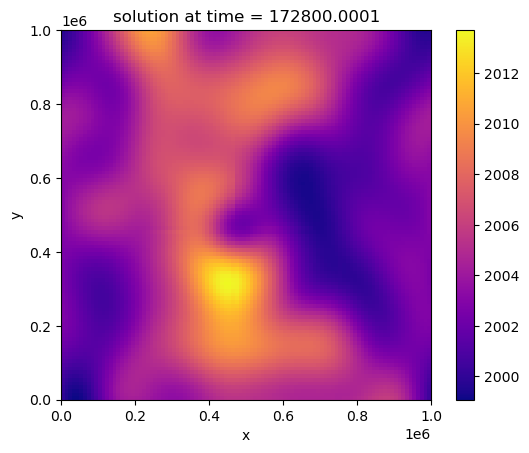

END OF SIMULATION
final phys time =  172800.0001
time of simulation =  55.53790211677551  secs


In [26]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  Здесь начинается основной код программы
#  
#######################################################################################################################
#######################################################################################################################
'''
#задаем границы нашей прямоугольной области
xmin = 0.0
xmax = 1000000.0
ymin = 0.0
ymax = 1000000.0

#для модельных задач dam_brak_x, dam_break_y, explosion и bathtub можно задавать область порядка единицы, 
# а для tsunami или atmosphere нужно задавать область в системе СИ порядка тысячи километров 
#(e.g. xmax = 1.000.000 м, phys_time_fin = 24*3600 - сутки) (см. выше)

#задаем количество ячеек вдоль направлений + число фиктивных ячеек
Nx = 100
Ny = 100
init_cond_type = 'atmosphere'

print('grid size is', Nx, 'x', Ny)

#создаем нашу двумерную сетку (структура-кортеж, т.к. в процессе расчета не меняется) 
grid = grid_setup_2D(xmin, xmax, ymin, ymax, Nx, Ny)

#создаем состояние среды (структура-словарь, т.к. изменяется со временем)
SWS0 = set_SW_State(grid) #начальное состояние (t = t0)
SWSh = set_SW_State(grid) #промежуточное состояние (при необходимости, здесь не используем)
SWS1 = set_SW_State(grid) #конечное состояние (t = t0 + dt)

#задаем начальное условие на нашей сетке + физические параметры 
SWS0, SWpar, phys_time_fin = SWE_init_cond(grid, SWS0, init_cond_type)

#инициализируем время
phys_time = 0.0
#инициализируем временной шаг
dt = 0.0
#инициализируем счетчик количества шагов
n_timestep = 0

#параметр Куранта-Фридрихса-Леви (CFL < 1 (1D) and CFL < 0.5 (2D))
if ((Nx > 1) and (Ny > 1)): 
    CFL = 0.4
else: 
    CFL = 0.8

# инициализируем графику для отрисовки во время расчета с последующим удалением кадра
line, ax, fig, im = plot_setup(grid, SWS0['h'] + SWpar.b, phys_time) #рисуем высоту столба жидкости с учетом дна

#задаем число шагов по времени, раз в которое мы отрисовываем наше решение 
n_snapshot = 20

#таймер для времени работы программы
start_time1 = time.time() 

#цикл по времени для эволюции системы 
while phys_time < phys_time_fin:

    '''обновляем счетчик шагов'''
    n_timestep = n_timestep + 1

    '''РАСЧЕТ ВРЕМЕННОГО ШАГА из условия Куранта-Фридрихса-Леви'''  
    #минимальный шаг по первому направлению
    dt1 = np.min(grid.dx/(np.abs(SWS0['vx'][2:-2, 2:-2]) + np.sqrt(SWS0['h'][2:-2, 2:-2]*SWpar.g)))
    #минимальный шаг по второму направлению
    dt2 = np.min(grid.dy/(np.abs(SWS0['vy'][2:-2, 2:-2]) + np.sqrt(SWS0['h'][2:-2, 2:-2]*SWpar.g)))
    #итоговый шаг по времени
    dt = min(CFL * min(dt1, dt2), phys_time_fin - phys_time)

    '''учет правой части (для учета источников мы используем т.н. расщепление (splitting) по процессам)'''
    #учет переменной формы дна и силы Кориолиса
    rhsx = - (dt/2.0) * SWpar.g * SWpar.b_x + (dt/2.0) * SWpar.f_c * SWS0['vy']
    rhsy = - (dt/2.0) * SWpar.g * SWpar.b_y - (dt/2.0) * SWpar.f_c * SWS0['vx'] 
    #добавляем их
    SWS0['vx'] = SWS0['vx'] + rhsx
    SWS0['vy'] = SWS0['vy'] + rhsy
    
    '''заполним фиктивные ячейки значениями в соответствии с граничными условиями'''  
    SWS0 = ghost_cells_SWE(grid, SWpar.BC, SWS0)
    
    '''кусочно-линейное уточнение по времени и пространству для переменных на гранях слева и справа от нее'''
    hlx, hrx, vxlx, vxrx, vylx, vyrx, hly, hry, vxly, vxry, vyly, vyry = rec_plm_SWE(grid, dt, SWpar.g, SWS0)

    '''расчет потоков сохраняющихся величин вдоль направления X'''
    if (grid.Nx > 1):
        fhx, fvxx, fvyx = Riemann_flux_SWE(hlx, hrx, vxlx, vxrx, vylx, vyrx, SWpar.g, 'x')
    else:
        #если по X одна ячейка, то у нас 1D задача, и потоки вдоль X можно не считать
        fhx = np.zeros((grid.Nx+1,grid.Ny),dtype = np.double)
        fvxx = np.zeros((grid.Nx+1,grid.Ny),dtype = np.double)
        fvyx = np.zeros((grid.Nx+1,grid.Ny),dtype = np.double)
        
    '''расчет потоков сохраняющихся величин вдоль направления Y'''
    if (grid.Ny > 1):
        fhy, fvxy, fvyy = Riemann_flux_SWE(hly, hry, vxly, vxry, vyly, vyry, SWpar.g, 'y')
    else: 
        #если по Y одна ячейка, то у нас 1D задача, и потоки вдоль Y можно не считать
        fhy = np.zeros((grid.Nx,grid.Ny+1),dtype = np.double)
        fvxy = np.zeros((grid.Nx,grid.Ny+1),dtype = np.double)
        fvyy = np.zeros((grid.Nx,grid.Ny+1),dtype = np.double)

    '''обновляем высоту'''
    SWS1['h'][2:-2, 2:-2] = SWS0['h'][2:-2, 2:-2] - \
        dt*( fhx[1:,:]*grid.fSx[1:,:] - fhx[:-1,:]*grid.fSx[:-1,:] + \
        fhy[:,1:]*grid.fSy[:,1:] - fhy[:,:-1]*grid.fSy[:,:-1] )/grid.cVol
    
    '''обновляем скорость вдоль x'''
    SWS1['vx'][2:-2, 2:-2] = (SWS0['h'][2:-2, 2:-2]*SWS0['vx'][2:-2, 2:-2] - \
        dt*(fvxx[1:,:]*grid.fSx[1:,:] - fvxx[:-1,:]*grid.fSx[:-1,:] + \
        fvxy[:,1:]*grid.fSy[:,1:] - fvxy[:,:-1]*grid.fSy[:,:-1])/grid.cVol)/SWS1['h'][2:-2, 2:-2]

    '''обновляем скорость вдоль y'''
    SWS1['vy'][2:-2, 2:-2] = (SWS0['h'][2:-2, 2:-2]*SWS0['vy'][2:-2, 2:-2] - \
        dt*(fvyx[1:,:]*grid.fSx[1:,:] - fvyx[:-1,:]*grid.fSx[:-1,:] + \
        fvyy[:,1:]*grid.fSy[:,1:] - fvyy[:,:-1]*grid.fSy[:,:-1])/grid.cVol)/SWS1['h'][2:-2, 2:-2]


    '''учет правой части (для учета источников мы используем т.н. расщепление (splitting) по процессам)'''
    #учет переменной формы дна и силы Кориолиса
    rhsx = - (dt/2.0) * SWpar.g * SWpar.b_x + (dt/2.0) * SWpar.f_c * SWS1['vy']
    rhsy = - (dt/2.0) * SWpar.g * SWpar.b_y - (dt/2.0) * SWpar.f_c * SWS1['vx'] 
    #добавляем их
    SWS1['vx'] = SWS1['vx'] + rhsx
    SWS1['vy'] = SWS1['vy'] + rhsy
    
    '''перезаписываем наше решение для перехода на следующий шаг'''
    SWS0['h'][2:-2, 2:-2] = SWS1['h'][2:-2, 2:-2]
    SWS0['vx'][2:-2, 2:-2] = SWS1['vx'][2:-2, 2:-2]
    SWS0['vy'][2:-2, 2:-2] = SWS1['vy'][2:-2, 2:-2]

    '''обновляем время'''
    phys_time = phys_time + dt

    '''отрисовка решения'''
    if ( (n_timestep % n_snapshot == 0) or (np.abs(phys_time - phys_time_fin) < 1e-14) ): 
        plotting(grid, SWS0['h'] + SWpar.b, phys_time, line, ax, fig, im) #рисуем высоту столба жидкости с учетом дна
        #plt.show()
        #plt.plot(grid.cx[Ng:-Ng,Ng], SWS1['vy'][Ng:-Ng,Ng])

#пишем сообщение об успешном завершении расчета
print("END OF SIMULATION")
#пишем финальное физическое время 
print("final phys time = ", phys_time)    

#пишем время исполнения программы 
end_time1 = time.time()
print("time of simulation = ", end_time1 - start_time1, " secs")
    

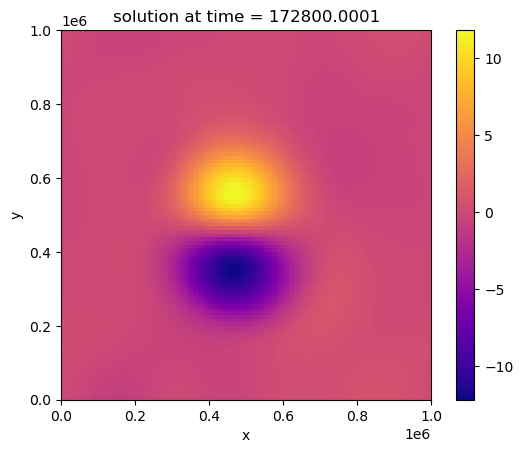

In [42]:
plotting(grid, SWS0['vx'], phys_time, line, ax, fig, im) #рисуем скорость жидкости вдоль X

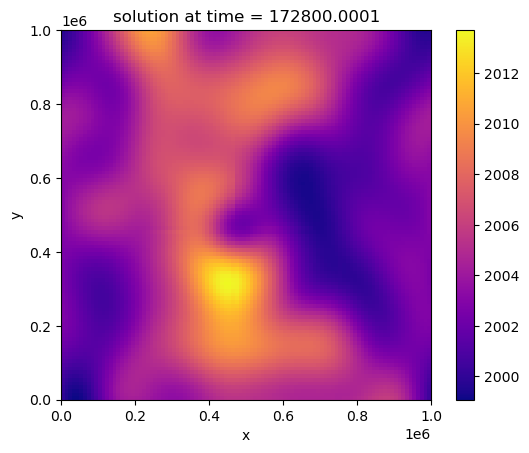

In [44]:
plotting(grid, SWS1['vx'], phys_time, line, ax, fig, im) #рисуем скорость жидкости вдоль Y